In [117]:
import community

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import pandas as pd
import os
import numpy as np
import networkx as nx

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from collections import Counter

In [14]:
dist_colors = ['yellow', 'purple', 'orange', '#96cde6', 'red', '#c0bd7f', '#7f7e80', '#5fa641', '#d485b2', 
              '#4277b6', '#df8461', '#463397', '#e1a11a', '#91218c', '#e8e948', '#7e1510',
              '#92ae31', '#6f340d', '#d32b1e', '#2b3514']

In [110]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

# Read data

In [6]:
files = list(os.walk('.'))[0][2]
files

['products_to_similar_items.csv',
 'products_to_categories.csv',
 'graph_sim_clustering.ipynb',
 'test_graph.ipynb',
 'products_to_review.csv',
 'categories.csv',
 'products.csv']

In [118]:
df_products_to_sim = pd.read_csv('products_to_similar_items.csv')
df_products_to_cat = pd.read_csv('products_to_categories.csv')
df_products_to_rev = pd.read_csv('products_to_review.csv')
df_categories = pd.read_csv('categories.csv')

In [119]:
df_products_to_sim = df_products_to_sim.set_index('id')
df_products_to_sim.head()

,similarItemASINs
id,
1,0804215715;156101074X;0687023955;0687074231;08...
2,0738700827;1567184960;1567182836;0738700525;07...
3,NaN
4,0842328130;0830818138;0842330313;0842328610;08...
5,157794349X;0892749504;1577941829;0892749563;15...


In [120]:
df_products_to_sim = df_products_to_sim.dropna()
df_products_to_sim.head()

,similarItemASINs
id,
1,0804215715;156101074X;0687023955;0687074231;08...
2,0738700827;1567184960;1567182836;0738700525;07...
4,0842328130;0830818138;0842330313;0842328610;08...
5,157794349X;0892749504;1577941829;0892749563;15...
6,0486401960;0452283612;0486229076;0714840343;03...


In [188]:
df_products = pd.read_csv('products.csv', escapechar='\\', quotechar='"')
df_products = df_products.set_index('id')
df_products = df_products.sort_index()
df_products.head(2)

,asin,discontinued,group,salesrank,title
id,,,,,
0,0771044445,True,NaN,-1,NaN
1,0827229534,False,Book,396585,Patterns of Preaching: A Sermon Sampler


In [122]:
df_products_to_sim = df_products_to_sim.sort_index()

In [123]:
df_products_to_sim['asin'] = df_products.loc[df_products_to_sim.index]['asin']
df_products_to_sim['group'] = df_products.loc[df_products_to_sim.index]['group']
df_products_to_sim.head()

,similarItemASINs,asin,group
id,,,
1,0804215715;156101074X;0687023955;0687074231;08...,0827229534,Book
2,0738700827;1567184960;1567182836;0738700525;07...,0738700797,Book
4,0842328130;0830818138;0842330313;0842328610;08...,0842328327,Book
5,157794349X;0892749504;1577941829;0892749563;15...,1577943082,Book
6,0486401960;0452283612;0486229076;0714840343;03...,0486220125,Book


In [124]:
df_products_to_sim = df_products_to_sim[df_products_to_sim['group'] == 'Book']
len(df_products_to_sim)

278773

In [157]:
len(df_products_to_sim.loc[df_products_to_sim.index & df_products.index])

278773

In [126]:
df_categories = df_categories.set_index('id')
df_categories = df_categories.sort_index()
df_categories.head(2)

,depthFromParent,highestParentFlag,lowestChildFlag,name,parentCategoryItem
id,,,,,
1,2,False,False,Arts & Photography,1000
2,2,False,False,Biographies & Memoirs,1000


In [132]:
df_products_to_cat = df_products_to_cat.set_index('id')
df_products_to_cat = df_products_to_cat.sort_index()
df_products_to_cat.head(2)

,category_ids
id,
1,283155;1000;22;12290;12360;12368;283155;1000;2...
2,283155;1000;22;12472;12484;283155;1000;22;1247...


In [133]:
df_products_to_rev.head()

,productId,date,customer,helpful,rating,votes
0,1,2000-07-28,A2JW67OY8U6HHK,9,5,10
1,1,2003-12-14,A2VE83MZF98ITY,5,5,6
2,2,2001-12-16,A11NCO6YTE4BTJ,4,5,5
3,2,2002-01-07,A9CQ3PLRNIR83,5,4,5
4,2,2002-01-24,A13SG9ACZ9O5IM,8,5,8


# Создаем граф

In [15]:
df_products_to_sim['similarItemASINs'] = df_products_to_sim['similarItemASINs'].map(lambda x: x.split(';'))
df_products_to_sim.head()

,similarItemASINs,asin,group
id,,,
1,"[0804215715, 156101074X, 0687023955, 068707423...",0827229534,Book
2,"[0738700827, 1567184960, 1567182836, 073870052...",0738700797,Book
4,"[0842328130, 0830818138, 0842330313, 084232861...",0842328327,Book
5,"[157794349X, 0892749504, 1577941829, 089274956...",1577943082,Book
6,"[0486401960, 0452283612, 0486229076, 071484034...",0486220125,Book


In [16]:
vertices = set(df_products_to_sim['asin'])

In [22]:
adj_list = {x:set(y) & vertices for (x,y) in zip(df_products_to_sim['asin'], 
                                                 df_products_to_sim['similarItemASINs']) }

Удаляем ребра, к которым нет парных

In [28]:
for u in adj_list:
    to_remove = set()
    for v in adj_list[u]:
        if u not in adj_list[v]:
            to_remove.add(v)
    adj_list[u] -= to_remove

Удаляем вершины, у которых нет соседей

In [32]:
adj_list = {k:v for k, v in adj_list.items() if v}

In [35]:
G = nx.from_dict_of_lists(adj_list)

In [36]:
len(G)

150846

In [37]:
nx.number_connected_components(G)

28746

In [38]:
Gcc = sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)

In [39]:
[len(cc) for cc in Gcc][:10]

[8555, 536, 427, 330, 312, 257, 238, 236, 230, 215]

# Communities

In [105]:
cur_G = Gcc[50]

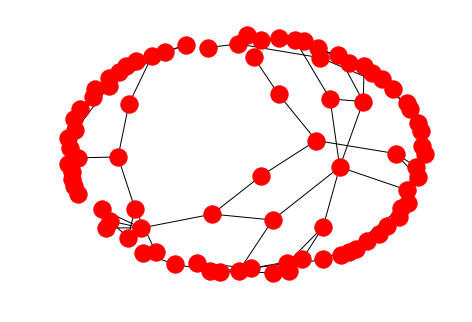

In [106]:
nx.draw(cur_G)
plt.show()

In [107]:
parts = community.best_partition(cur_G)

In [108]:
values = [dist_colors[parts.get(node)] for node in cur_G.nodes()]

In [146]:
pos = community_layout(cur_G, parts)

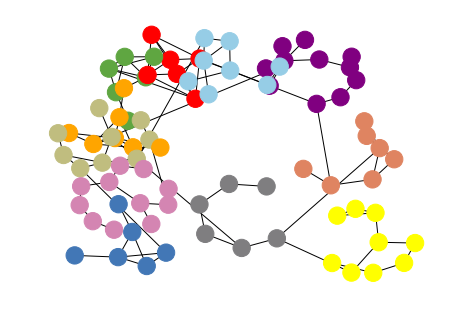

In [147]:
nx.draw(cur_G, pos=pos, node_color=values)
plt.show()

In [190]:
df_products['id'] = df_products.index
df_products = df_products.set_index('asin')
df_products.head(2)

,discontinued,group,salesrank,title,id
asin,,,,,
0771044445,True,NaN,-1,NaN,0
0827229534,False,Book,396585,Patterns of Preaching: A Sermon Sampler,1


The Great Women Cartoonists
The Great Women Superheroes
Girls Guide to Taking Over the World : Writings From The Girl Zine Revolution
Zine Scene: The Do It Yourself Guide to Zines
The Bust Guide to the New Girl Order
Notes from Underground: Zines and the Politics of Alternative Culture (Haymarket Series)
Make a Zine!
From Girls to Grrlz : A History of Women's Comics from Teens to Zines
Zines


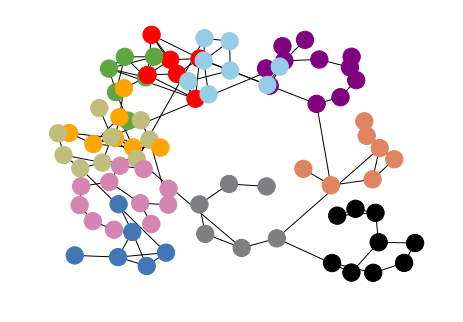

In [180]:
k = 0
for s in [df_products.loc[node, 'title'] for node in cur_G.nodes() if parts.get(node) == k]:
    print(s)
values = [dist_colors[parts.get(node)] if parts.get(node) != k else 'black' for node in cur_G.nodes()]
nx.draw(cur_G, pos=pos, node_color=values)
plt.show()

The Left-Hander Syndrome : The Causes and Consequences of Left-Handedness
Loving Lefties : How to Raise Your Left-Handed Child in a Right-Handed World
Left Is Right: The Survival Guide for Living Lefty in a Right-Handed World
The Left-Handed Book
The Natural Superiority of the Left-Hander
Left-Handed Kids : Why Are They So Different
Left-Handed Calligraphy


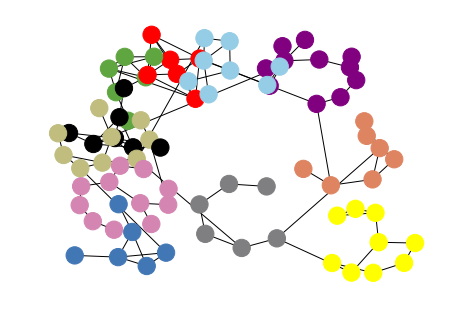

In [179]:
k = 2
for s in [df_products.loc[node, 'title'] for node in cur_G.nodes() if parts.get(node) == k]:
    print(s)
values = [dist_colors[parts.get(node)] if parts.get(node) != k else 'black' for node in cur_G.nodes()]
nx.draw(cur_G, pos=pos, node_color=values)
plt.show()

The Body Project : An Intimate History of American Girls
The Second Sex (Vintage)
A Vindication of the Rights of Woman (Dover Thrift Editions)
The Subjection of Women (Dover Thrift Editions)
The Beauty Myth : How Images of Beauty Are Used Against Women
Backlash : The Undeclared War Against American Women
The Feminine Mystique
Girl Culture
Stiffed: The Betrayal of the American Man


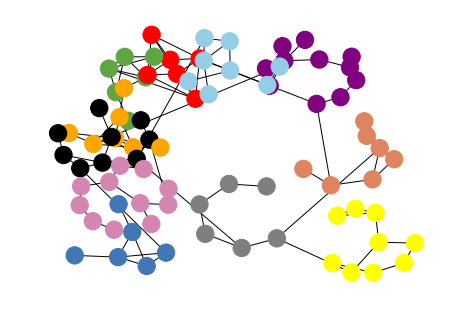

In [178]:
k = 5
for s in [df_products.loc[node, 'title'] for node in cur_G.nodes() if parts.get(node) == k]:
    print(s)
values = [dist_colors[parts.get(node)] if parts.get(node) != k else 'black' for node in cur_G.nodes()]
nx.draw(cur_G, pos=pos, node_color=values)
plt.show()

# Кластеризация пользователей

In [191]:
df_products.head(2)
df_products.head(2)

,discontinued,group,salesrank,title,id
asin,,,,,
0771044445,True,NaN,-1,NaN,0
0827229534,False,Book,396585,Patterns of Preaching: A Sermon Sampler,1


In [181]:
df_products_to_rev.head()

,productId,date,customer,helpful,rating,votes
0,1,2000-07-28,A2JW67OY8U6HHK,9,5,10
1,1,2003-12-14,A2VE83MZF98ITY,5,5,6
2,2,2001-12-16,A11NCO6YTE4BTJ,4,5,5
3,2,2002-01-07,A9CQ3PLRNIR83,5,4,5
4,2,2002-01-24,A13SG9ACZ9O5IM,8,5,8
